In [36]:
import numpy as np
import torch
import cv2
import os
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor
import matplotlib.pyplot as plt
from PIL import Image
import cv2
from pycocotools.coco import COCO
from skimage.draw import polygon
import monai


## Load Dataset

In [37]:
train_dir = 'cv/datasets/train'
test_dir = 'cv/datasets/test'
val_dir = 'cv/datasets/valid'

train_annotation_file = 'cv/datasets/train/_annotations.coco.json'
test_annotation_file = 'cv/datasets/test/_annotations.coco.json'
val_annotation_file = 'cv/datasets/valid/_annotations.coco.json'

coco_train = COCO(train_annotation_file)
coco_test = COCO(test_annotation_file)
coco_val = COCO(val_annotation_file)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


## DataPreprocessing

In [38]:
import os
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
import numpy as np
import torch
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon

from PIL import Image
import cv2
from pycocotools.coco import COCO
from skimage.draw import polygon
from skimage.measure import label, centroid
from transformers import AutoProcessor, CLIPSegForImageSegmentation
import albumentations as A
import ml_dtypes

device = torch.device("cuda")

clipseg_processor = AutoProcessor.from_pretrained("CIDAS/clipseg-rd64-refined")
clipseg_model = CLIPSegForImageSegmentation.from_pretrained("CIDAS/clipseg-rd64-refined")
clipseg_model.load_state_dict(torch.load("cv/finetuned_CLIPSeg.pth", weights_only=True))
clipseg_model.eval()

def infer_clipseg(img, model=clipseg_model, processor=clipseg_processor):
  texts = ['tumor in brain']
  new_size = (352, 352)
  model = model.to(device)

  transform = A.Resize(new_size[0], new_size[1])

  augmented = transform(image=np.array(img))
  img_transformed = augmented['image']

  inputs = processor(text=texts, images=[img_transformed] * len(texts), padding=True, return_tensors="pt").to(device)

  output_mask = model(**inputs, interpolate_pos_encoding=True)[0]
  binary_output_mask = torch.sigmoid(output_mask) > 0.5

  return np.squeeze(binary_output_mask.cpu().detach().float().numpy(), 0)

def generate_prompt(img, demo=False):
  initial_mask = infer_clipseg(img)
  labels, num_masks = label(initial_mask, return_num=True)
  biggest = [0,0]
  for i in range(1, num_masks+1): # pick the biggest area's centroid
    area=np.sum(labels==i)
    if area>biggest[1]:
      biggest = [i, area]

  prompt_y, prompt_x = centroid(labels==biggest[0])
  width, height = img.shape[0], img.shape[1]
  
  def scale(point, size): return np.round(point*size/352).astype(int)

  prompt_point = (scale(prompt_x, width) , scale(prompt_y, height)) # scale it back

  if demo:
    return prompt_point, initial_mask, (prompt_x, prompt_y)
  else:
    return np.array([prompt_point[0], prompt_point[1]])

In [39]:
def create_mask(image_id, coco, height, width):
    coords = []
    mask = np.zeros((height, width), dtype=np.uint8)
    annotation_ids = coco.getAnnIds(imgIds=image_id)
    annotations = coco.loadAnns(annotation_ids)
    for annotation in annotations:
        for seg in annotation['segmentation']:
            poly = np.array(seg).reshape((int(len(seg) / 2), 2))
            rr, cc = polygon(poly[:, 1], poly[:, 0], (height, width))
            mask[rr, cc] = 1
            cd = np.mean(poly, axis=0)
            coords.append(cd)
    # print(coords)
    middle_coord = np.mean(coords, axis=0)
    # print(coords, middle_coord)
    return mask, middle_coord

def create_dataset(data_dir, coco):
    img_ids = coco.getImgIds()
    image_list = []
    mask_list = []
    coord_list = []
    for img_id in img_ids:
        img_info = coco.loadImgs(img_id)[0]
        img_path = os.path.join(data_dir, img_info['file_name'])
        img = Image.open(img_path)
        img = np.array(img.convert("RGB"))


        if img is not None:
            mask, coord = create_mask(img_id, coco, img_info['height'], img_info['width'])
            coord = generate_prompt(img)
            mask = np.expand_dims(mask, axis=-1)
            mask[mask > 0.5] = 1
            mask[mask <= 0.5] = 0
            image_list.append(img)
            mask_list.append(mask)
            coord_list.append(coord)
    return image_list, mask_list, coord_list

In [40]:
img_list, mask_list, coord_list = create_dataset(train_dir, coco_train)

/scratch/xc1626/conda_envs/sam2/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/scratch/xc1626/conda_envs/sam2/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


## Create PyTorch dataset


In [41]:
from torch.utils.data import Dataset

class SAMDataset(Dataset):
  def __init__(self, img_list, mask_list, point_list):
    self.img_list = img_list
    self.mask_list = mask_list
    self.point_list = point_list
  

  def __len__(self):
    return len(self.img_list)

  def __getitem__(self, idx):
    return {'img': self.img_list[idx], 
            'mask': self.mask_list[idx], 
            'prompt': self.point_list[idx]}

In [42]:
train_dataset = SAMDataset(img_list, mask_list, coord_list)

## Load model

In [ ]:
from hydra.core.global_hydra import GlobalHydra
if GlobalHydra.instance().is_initialized():
    GlobalHydra.instance().clear()

from hydra import initialize_config_dir, compose
from hydra.utils import instantiate

# Change config dir to your file location
initialize_config_dir(config_dir="/scratch/xc1626/sam2/sam2/configs/sam2.1")

hydra_overrides_extra = [
            # dynamically fall back to multi-mask if the single mask is not stable
            "++model.sam_mask_decoder_extra_args.dynamic_multimask_via_stability=true",
            "++model.sam_mask_decoder_extra_args.dynamic_multimask_stability_delta=0.05",
            "++model.sam_mask_decoder_extra_args.dynamic_multimask_stability_thresh=0.98",
        ]
sam2_checkpoint = "/scratch/xc1626/sam2/checkpoints/sam2.1_hiera_large.pt"
model_cfg = compose(config_name="sam2.1_hiera_l.yaml", overrides=hydra_overrides_extra)
model = instantiate(model_cfg.model, _recursive_=True)
sd = torch.load(sam2_checkpoint, map_location="cpu", weights_only=True)["model"]
missing_keys, unexpected_keys = model.load_state_dict(sd)
model = model.to(device)
model.train()


from sam2.sam2_image_predictor import SAM2ImagePredictor
predictor = SAM2ImagePredictor(model)

/tmp/ipykernel_1756882/2625948936.py:8: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  initialize_config_dir(config_dir="/scratch/xc1626/sam2/sam2/configs/sam2.1")


## Train the model

In [44]:
from torch.optim import Adam
import monai

# Train mask decoder.
predictor.model.sam_mask_decoder.train(True)

# Train prompt encoder.
predictor.model.sam_prompt_encoder.train(False)


# No. of steps to train the model.
num_epochs = 5

optimizer=torch.optim.Adam(params=predictor.model.parameters(),lr=1e-5,weight_decay=4e-5) #1e-5, weight_decay = 4e-5
seg_loss = monai.losses.DiceCELoss(sigmoid=True, squared_pred=True, reduction='mean')
scaler = torch.cuda.amp.GradScaler()
FINE_TUNED_MODEL_NAME = "fine_tuned_sam2"


In [45]:
from tqdm import tqdm
from statistics import mean
import torch
from torch.nn.functional import threshold, normalize

num_epochs = 2
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=500, gamma=0.2) # 500 , 250, gamma = 0.1
accumulation_steps = 4  # Number of steps to accumulate gradients before updating
for epoch in range(num_epochs):
    epoch_losses = []
    for idx in tqdm(range(len(train_dataset))):
      # forward pass
        mask = torch.tensor(train_dataset[idx]['mask'].reshape(1, 640, 640)).to(device)
        img = train_dataset[idx]['img']
        prompt = train_dataset[idx]['prompt'].reshape(1, 1, 2)
        predictor.set_image(img)
        mask_input, unnorm_coords, labels, unnorm_box = predictor._prep_prompts(prompt, np.array([[1]]), box=None, mask_logits=None, normalize_coords=True)
        if unnorm_coords is None or labels is None or unnorm_coords.shape[0] == 0 or labels.shape[0] == 0:
           continue

        sparse_embeddings, dense_embeddings = predictor.model.sam_prompt_encoder(
            points=(unnorm_coords, labels), boxes=None, masks=None,
        )

        batched_mode = unnorm_coords.shape[0] > 1
        high_res_features = [feat_level[-1].unsqueeze(0) for feat_level in predictor._features["high_res_feats"]]
        low_res_masks, prd_scores, _, _ = predictor.model.sam_mask_decoder(
            image_embeddings=predictor._features["image_embed"][-1].unsqueeze(0),
            image_pe=predictor.model.sam_prompt_encoder.get_dense_pe(),
            sparse_prompt_embeddings=sparse_embeddings,
            dense_prompt_embeddings=dense_embeddings,
            multimask_output=False,
            repeat_image=batched_mode,
            high_res_features=high_res_features,
        )
        prd_masks = predictor._transforms.postprocess_masks(low_res_masks, predictor._orig_hw[-1])[0]
        loss = seg_loss(prd_masks, mask)

        # Apply gradient accumulation
        loss = loss / accumulation_steps
        scaler.scale(loss).backward()
        epoch_losses.append(loss.item())

        # Clip gradients
        torch.nn.utils.clip_grad_norm_(predictor.model.parameters(), max_norm=1.0)

        if idx % accumulation_steps == 0:
            scaler.step(optimizer)
            scaler.update()
            predictor.model.zero_grad()

        # Update scheduler
        scheduler.step()

    print(f'EPOCH: {epoch}')
    print(f'Mean loss: {mean(epoch_losses)}')

  0%|                                                                                          | 0/1502 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████| 1502/1502 [00:57<00:00, 26.21it/s]


EPOCH: 0
Mean loss: 38.299524122742454


100%|███████████████████████████████████████████████████████████████████████████████| 1502/1502 [00:57<00:00, 26.29it/s]

EPOCH: 1
Mean loss: 38.29521049568045


In [46]:
# save model checkpoint

torch.save({
    'model_state_dict': predictor.model.state_dict(),
}, "sam2_finetuned.pth")

## Evaluation

In [47]:
import numpy as np
from typing import Iterator
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from PIL import Image
import torch

from transformers import AutoProcessor, CLIPSegForImageSegmentation
import albumentations as A

from sklearn.metrics import jaccard_score

imgs_test=np.load("cv/4.npy")
msks_test=np.load("cv/5.npy")

In [48]:
device = torch.device('cuda')
if device.type == "cuda":
    # use bfloat16 for the entire notebook
    torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    if torch.cuda.get_device_properties(0).major >= 8:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
def evaluate(test_data: Iterator, predictor, transformation=lambda mask: mask, num_visualized=3) -> float:
  """
  test_data: contains an iterator of tuples. First element of which should be the image, the another should be the ground truth mask.
             Both of type np.ndarray
  predictor: a function, where given an image, outputs its predicted segmentation mask as an numpy array in the CPU. The mask should be binary
  transformation: a function that transforms the ground truth mask to the same form as the predicted mask
  """
  sum_iou = 0
  num_images = 0

  visualizations = []

  for im, gt_mask in test_data:
    predictor.set_image(im)
    coord = generate_prompt(im).reshape(1, 1, 2)
    pred_mask = predictor.predict(coord, np.ones((1, 1)), multimask_output=False)[0]
    intersection = np.logical_and(gt_mask, pred_mask)
    union = np.logical_or(gt_mask, pred_mask)
    iou_score = np.sum(intersection) / np.sum(union)

    if len(visualizations) < 10:
      visualizations.append((im, gt_mask, pred_mask, iou_score))

    sum_iou+=iou_score
    num_images+=1

  for im, gt_mask, pred_mask, iou_score in visualizations:
    fig, ax = plt.subplots(1, 3, figsize=(15, 20))
    ax[0].imshow(im)
    ax[0].set_title('Image')
    ax[1].imshow(gt_mask)
    ax[1].set_title('Ground Truth Mask')
    ax[2].imshow(pred_mask.reshape(640, 640, 1))
    ax[2].set_title(f'Predicted Mask: IoU={np.round(iou_score, decimals=5)}')

  plt.show()

  return sum_iou/num_images

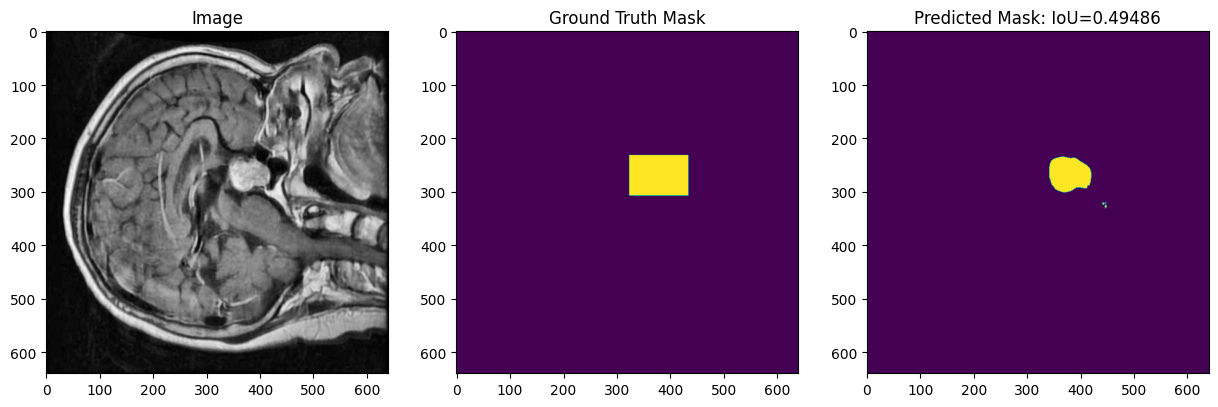

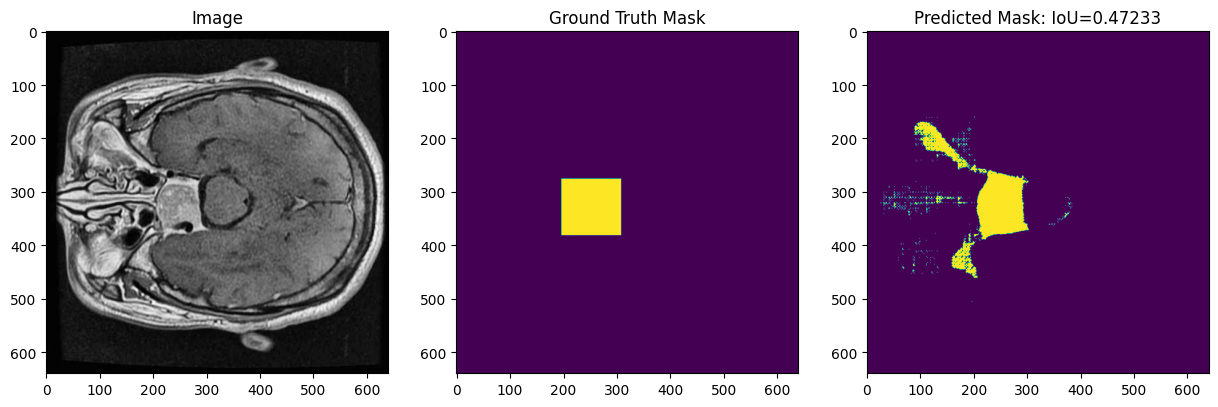

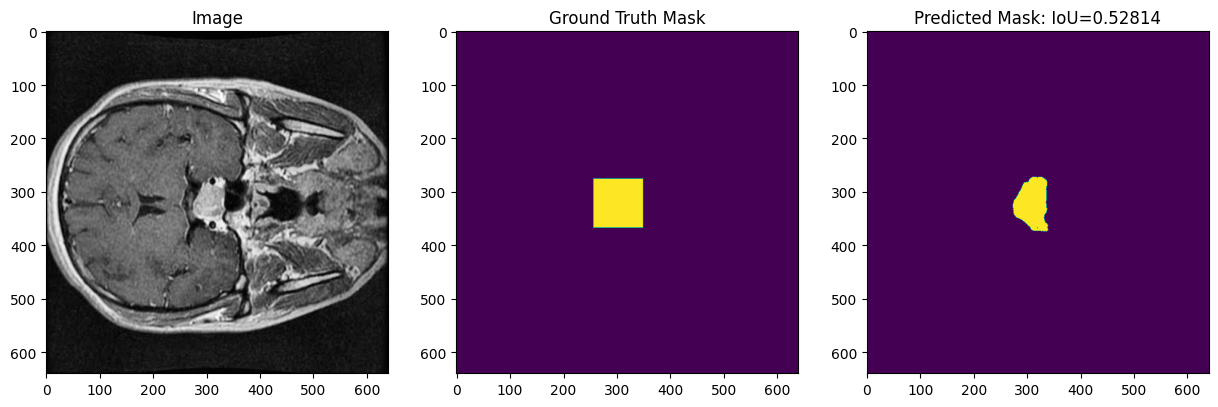

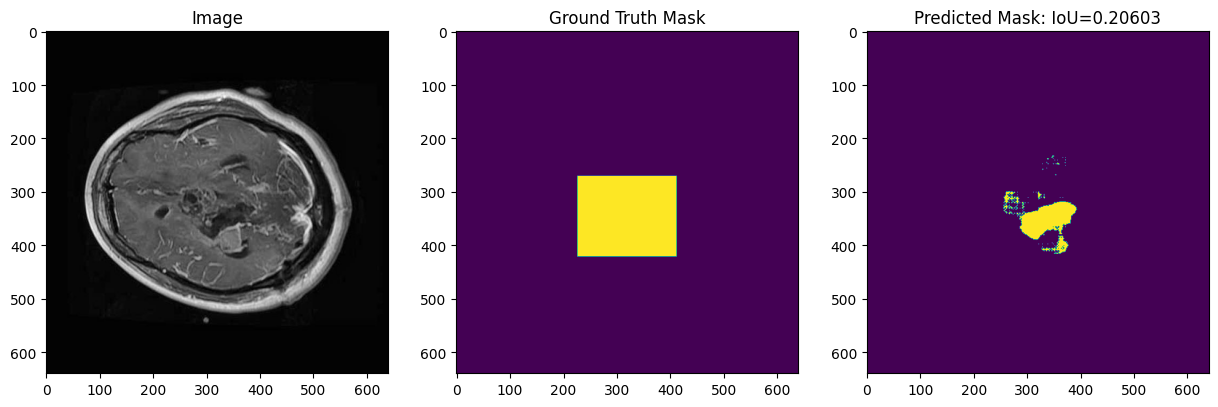

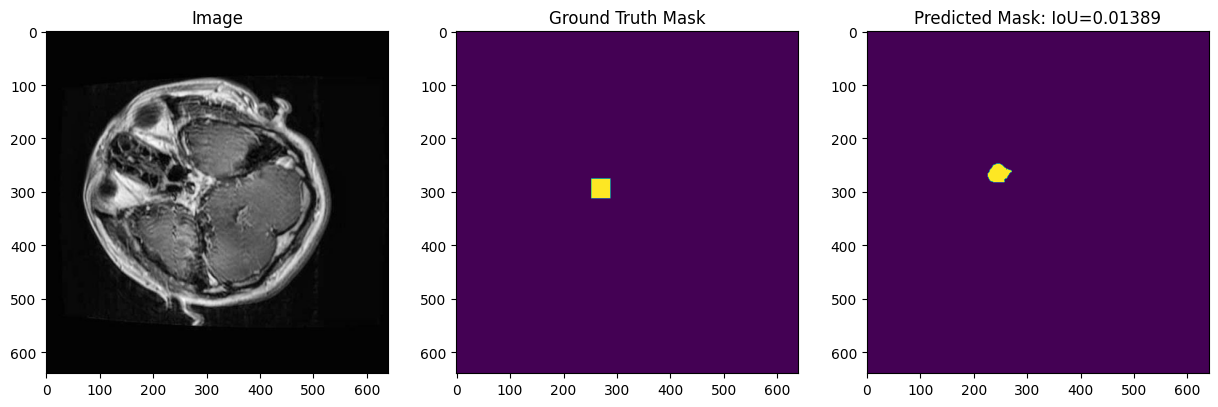

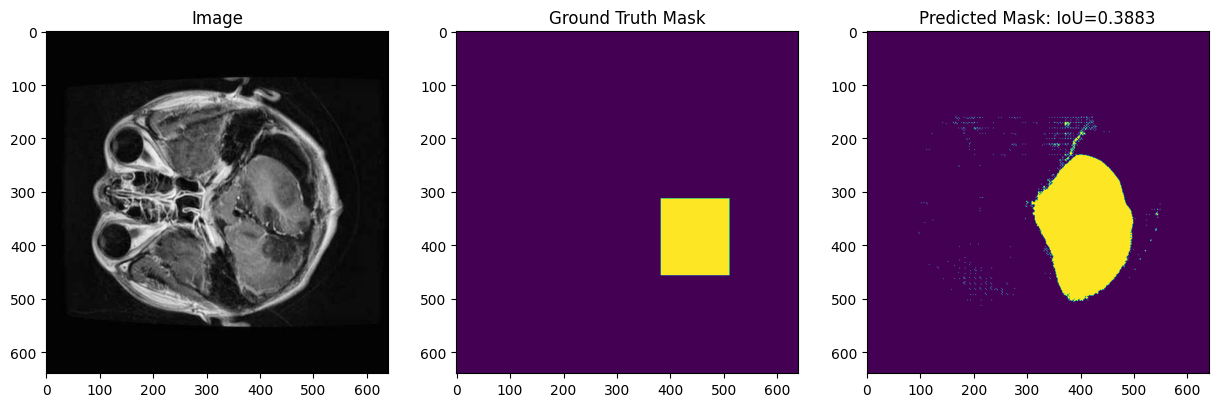

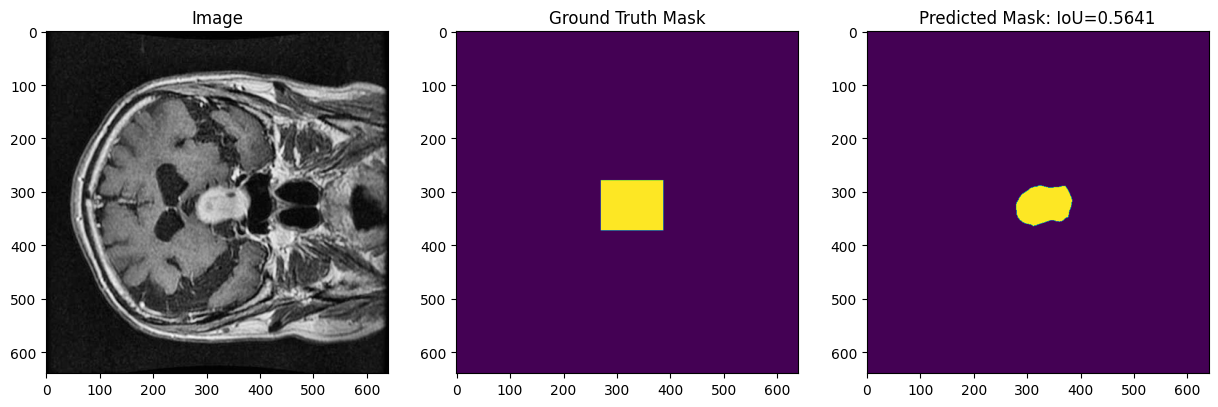

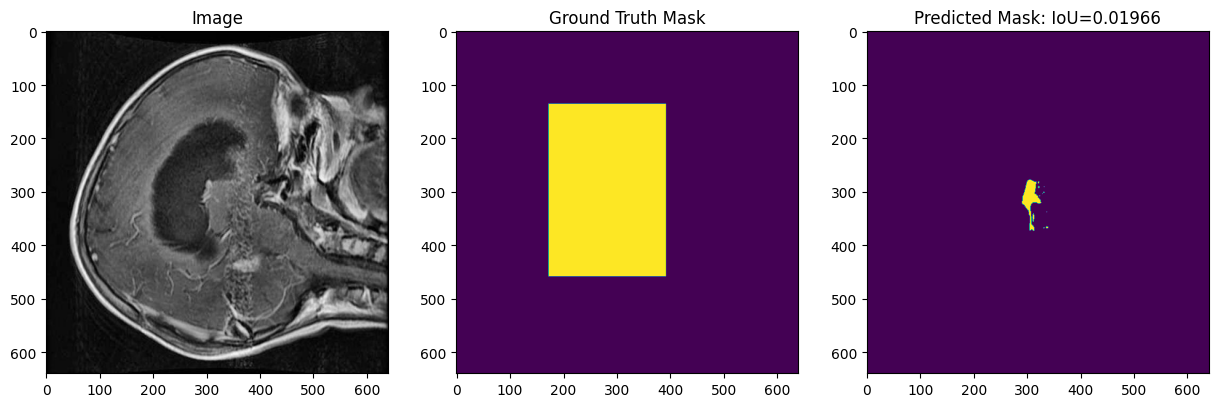

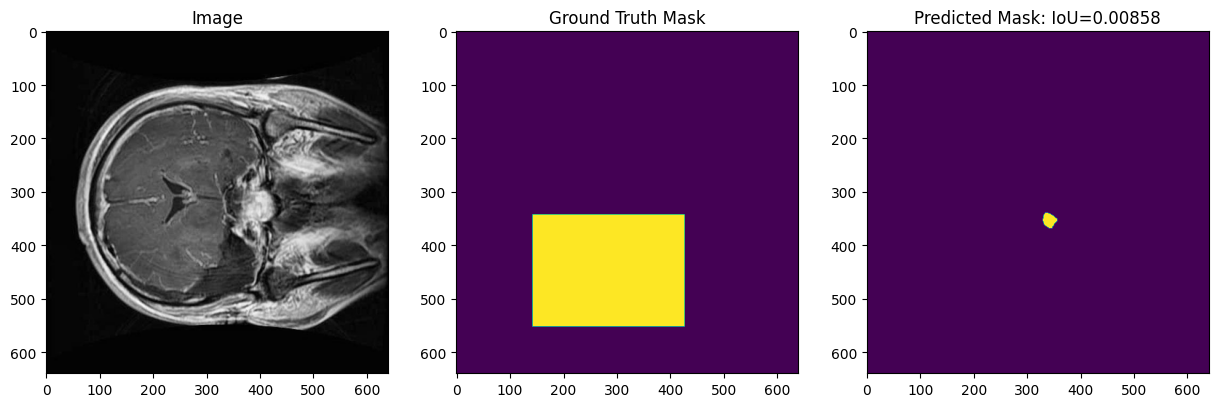

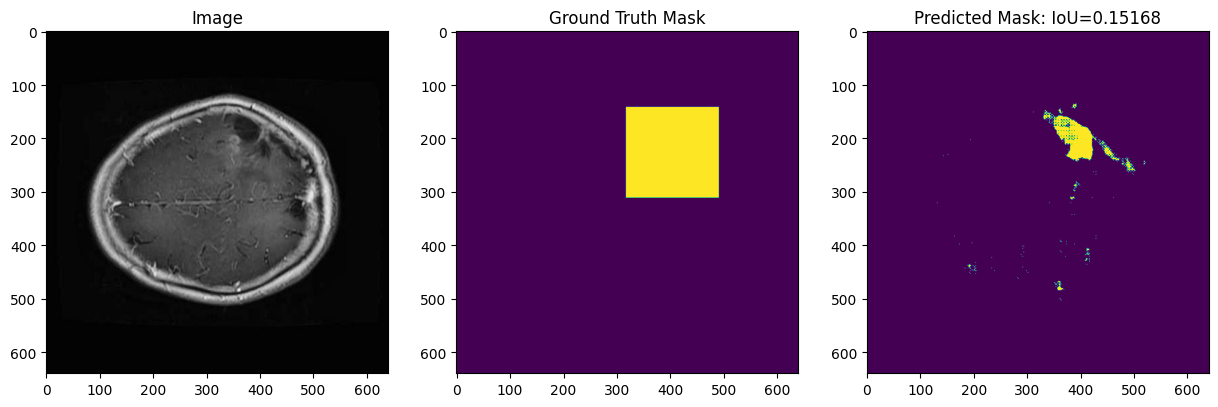

In [49]:
mean_iou_sam2 = evaluate(
    test_data=zip(imgs_test, msks_test),
    predictor=predictor,
    transformation=lambda mask: A.Resize(352, 352)(image=mask)['image']
)

In [50]:
mean_iou_sam2

0.2980826751060503